In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.models import Sequential
import keras
from tensorflow.keras.optimizers import RMSprop
import cv2
import os
import shutil

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.optimizers import Adamax, Adam, RMSprop
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

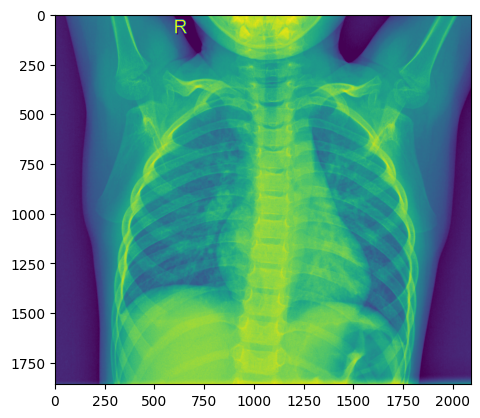

In [9]:
img = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg', cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [10]:
img.shape

(1858, 2090)

In [11]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm  # Progress bar

# Define Albumentations Augmentations
def get_train_augs():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.2),
        A.Blur(blur_limit=(3, 7), p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
    ], p=1.0)

# Function to load and augment an image and save it in a new directory
def augment_and_save(image_path, save_dir, augmentations, num_copies=2):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0  # Normalize
    
    filename = os.path.basename(image_path).split('.')[0]  # Get file name without extension

    for i in range(num_copies):
        augmented = augmentations(image=image)
        aug_image = (augmented['image'] * 255).astype(np.uint8)  # Convert back to uint8
        
        # Save augmented image in the new directory
        save_path = os.path.join(save_dir, f"{filename}_aug_{i}.jpeg")
        cv2.imwrite(save_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

# Function to balance 'NORMAL' class and save in a new dataset folder
def balance_normal_class(original_data_dir, new_data_dir, num_augment_per_image=2):
    original_normal_path = os.path.join(original_data_dir, "NORMAL")
    pneumonia_path = os.path.join(original_data_dir, "PNEUMONIA")

    new_train_dir = os.path.join(new_data_dir, "train")
    new_normal_dir = os.path.join(new_train_dir, "NORMAL")
    new_pneumonia_dir = os.path.join(new_train_dir, "PNEUMONIA")

    # Create new dataset structure
    os.makedirs(new_normal_dir, exist_ok=True)
    os.makedirs(new_pneumonia_dir, exist_ok=True)

    # Copy original NORMAL images to new dataset
    normal_images = [os.path.join(original_normal_path, img) for img in os.listdir(original_normal_path) if img.endswith(('.jpeg', '.png', '.jpg'))]
    for img_path in normal_images:
        shutil.copy(img_path, new_normal_dir)

    # Copy PNEUMONIA images to new dataset
    pneumonia_images = [os.path.join(pneumonia_path, img) for img in os.listdir(pneumonia_path) if img.endswith(('.jpeg', '.png', '.jpg'))]
    for img_path in pneumonia_images:
        shutil.copy(img_path, new_pneumonia_dir)

    # Get the number of images
    pneumonia_count = len(pneumonia_images)
    normal_count = len(normal_images)

    images_needed = pneumonia_count - normal_count  # Target: Match pneumonia count
    
    if images_needed <= 0:
        print("Dataset is already balanced!")
        return

    print(f"Balancing 'NORMAL' class by adding {images_needed} images...")

    # Apply augmentation and save in new dataset directory
    for img_path in tqdm(normal_images, desc="Augmenting NORMAL class"):
        augment_and_save(img_path, new_normal_dir, get_train_augs(), num_copies=num_augment_per_image)

# Run the function
original_data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"  # Original unbalanced dataset
new_data_dir = "/kaggle/working/chest_xray_balanced"  # New balanced dataset

balance_normal_class(original_data_dir, new_data_dir, num_augment_per_image=2)

print("✅ Augmented images saved in:", new_data_dir)

Balancing 'NORMAL' class by adding 2534 images...


Augmenting NORMAL class: 100%|██████████| 1341/1341 [08:51<00:00,  2.52it/s]

✅ Augmented images saved in: /kaggle/working/chest_xray_balanced


In [15]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_dataset_from_directory(data_dir, original_test_dir, target_size=(224, 224), batch_size=32, validation_split=0.2):
    train_dir = os.path.join(data_dir, 'train')  
    test_dir = os.path.join(data_dir, 'test')  # This doesn't exist in your new dataset

    if not os.path.exists(train_dir):
        print(f"❌ Train directory not found: {train_dir}")
        return None, None, None

    if not os.path.exists(test_dir):
        print(f"⚠️ Test directory not found: Using original test directory.")
        test_dir = original_test_dir  # Use the original test dataset

    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

    train_dataset = datagen.flow_from_directory(
        train_dir,  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training' 
    )

    val_dataset = datagen.flow_from_directory(
        train_dir,  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_dataset = test_datagen.flow_from_directory(
        test_dir,  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_dataset, val_dataset, test_dataset

# ✅ Call the function with the correct paths
data_dir = "/kaggle/working/chest_xray_balanced"
original_test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

train_dataset, val_dataset, test_dataset = load_dataset_from_directory(data_dir, original_test_dir)

⚠️ Test directory not found: Using original test directory.
Found 6319 images belonging to 2 classes.
Found 1579 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
import os

train_normal = len(os.listdir("/kaggle/working/chest_xray_balanced/train/NORMAL"))
train_pneumonia = len(os.listdir("/kaggle/working/chest_xray_balanced/train/PNEUMONIA"))

print(f"Balanced Training Data:")
print(f"NORMAL: {train_normal} images")
print(f"PNEUMONIA: {train_pneumonia} images")

Balanced Training Data:
NORMAL: 4023 images
PNEUMONIA: 3875 images


In [17]:
train_dataset.image_shape
val_dataset.image_shape
test_dataset.image_shape

(224, 224, 3)

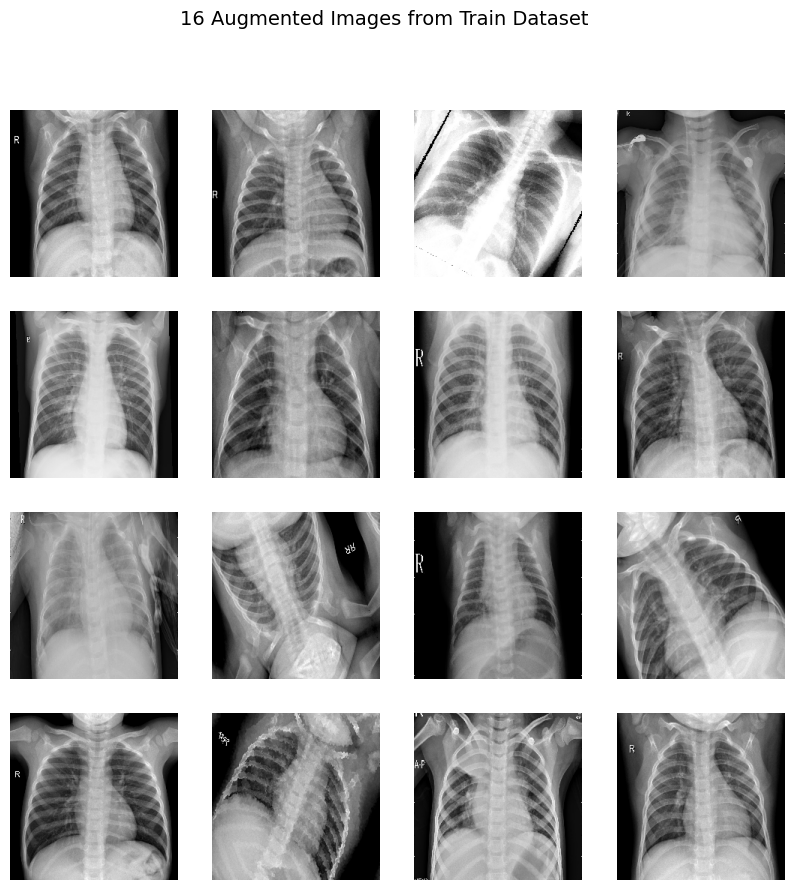

In [18]:
import matplotlib.pyplot as plt

img_batch, label_batch = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img_batch[i]) 
    plt.axis('off')

plt.suptitle("16 Augmented Images from Train Dataset", fontsize=14)
plt.show()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [20]:
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)
class_count = 1

model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=image_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(class_count, activation='sigmoid')
    ])

model.compile(optimizer=Adamax(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_loss',mode='min',patience=7)

In [23]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,  
    epochs=30, 
    callbacks=[early_stopping]
)

Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 87s 391ms/step - accuracy: 0.7202 - loss: 0.6739 - val_accuracy: 0.9341 - val_loss: 0.1646
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 364ms/step - accuracy: 0.9223 - loss: 0.2100 - val_accuracy: 0.9341 - val_loss: 0.1619
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 361ms/step - accuracy: 0.9374 - loss: 0.1711 - val_accuracy: 0.9639 - val_loss: 0.1021
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 357ms/step - accuracy: 0.9531 - loss: 0.1276 - val_accuracy: 0.9677 - val_loss: 0.0897
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 362ms/step - accuracy: 0.9636 - loss: 0.1040 - val_accuracy: 0.9709 - val_loss: 0.0863
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 363ms/step - accuracy: 0.9695 - loss: 0.0925 - val_accuracy: 0.9709 - val_loss: 0.0889
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 361ms/step - accuracy: 0.9723 - loss: 0.0780 - val_accuracy: 0.9690 - val_loss: 0.0991
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 362ms/step - accuracy: 0.9717 - loss: 0

In [24]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Val Accuracy: {val_acc:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.9726 - loss: 0.0751
Val Accuracy: 0.9753


In [25]:
final_train_acc = history.history['accuracy'][-1] 
print(f"Final Training Accuracy: {final_train_acc:.4f}")

Final Training Accuracy: 0.9916


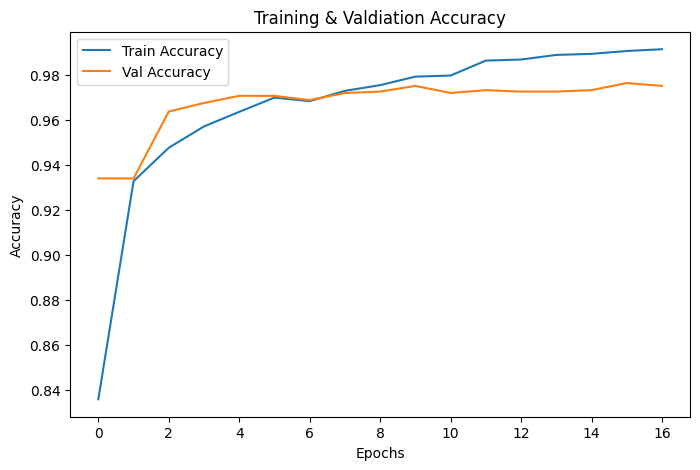

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Valdiation Accuracy")
plt.legend()
plt.show()